In [ ]:
import numpy as np
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import pandas as pd
import cv2
import os
import glob
from tensorflow.keras import regularizers
from tensorflow.keras.models import Sequential
from tensorflow.keras import initializers
from tensorflow.keras.layers import Dense, Conv2D, Flatten, Dropout, MaxPooling2D, BatchNormalization

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
def load_data(x): # flag 1 for training data, 0 for testing data
    drct = r"/content/drive/MyDrive/SoyabeanWilting/data/TrainDataC2/" #/data/TrainDataC2/
    
    imgL = []
    if x:
        df = pd.read_csv('/content/drive/MyDrive/SoyabeanWilting/data/TrainAnnotations.csv')  #/data/TrainAnnotations.csv
        for i in range(len(df.annotation)):

            name = str(df.file_name[i])      # read the file name from the annotation csv
            path = drct+name
            img = cv2.imread(path)           # Read the corresponding image
            img = cv2.resize(img,(224,224))  # Resize all images to (224, 224) 
            imgL.append(img) 

        data = np.array(imgL)                # Convert list of images to numpy array
        clas = df.annotation.values  
        return data, clas                    # return images and class labels

    else: 
        img_dir = "/content/drive/MyDrive/SoyabeanWilting/data/TestData" # Enter Directory of test images 
        data_path = os.path.join(img_dir,'*g')
        files = glob.glob(data_path)
        data=[]
        for f1 in files: 
          img = cv2.imread(f1)               # Read the image in the test directory
          img = cv2.resize(img,(224,224))    # Resize the image 
          data.append(img)   
        data = np.array(data)
        return data                          # Return the array of test images

In [ ]:
x_train, y_train =  load_data(1)
x_train.shape, y_train.shape

((1275, 224, 224, 3), (1275,))

In [ ]:
x_test = load_data(0)
x_test.shape

(200, 224, 224, 3)

In [ ]:
def get_dir(x,y):
    d_dir = {0:[],1:[],2:[],3:[],4:[]}

    for i in range(len(y)):
        for c in range(5):
            if y[i] == c: 
                d_dir[c].append(x[i])
                break
    return d_dir

In [ ]:
def augment(image_arr, d):
    aug_list = np.ndarray(image_arr.shape[1:])
    aug_list = np.expand_dims(aug_list, axis=0)

    for i in range(d//4):

      image = image_arr[i]                              # Read the image 
      flipped = tf.image.flip_left_right(image)         # Flip the image across verticle axis
      saturated = tf.image.adjust_saturation(image, 2)  # Add color saturation to the image
      bright = tf.image.adjust_brightness(image, 0.1)   # Add brightness to the image
      rotated = tf.image.rot90(image)                   # Rotate the image 90 dec right
      
      aug_list = np.vstack((aug_list, np.expand_dims(flipped, axis=0)))
      aug_list = np.vstack((aug_list, np.expand_dims(saturated, axis=0)))
      aug_list = np.vstack((aug_list, np.expand_dims(bright, axis=0)))
      aug_list = np.vstack((aug_list, np.expand_dims(rotated, axis=0)))

    return aug_list

In [ ]:
# creating balanced validation dataset
splitList = [0.08, 0.12, 0.31, 0.30, 0.20]
data_dir = get_dir(x_train, y_train)

for i in range(len(splitList)):
  data = np.array(data_dir[i])
  label = i*np.ones((len(data)))
  train_X, test_X, train_y, test_y = train_test_split(data, label, test_size=splitList[i])

  # No augmentation for class zero
  if i == 0:
    train_data = train_X
    train_label = train_y
    val_data = test_X
    val_label = test_y

  # Augmentation for class 1, 2, 3 and 4
  else:
    d = len(data_dir[0]) - len(data_dir[i])
    aug = augment(train_X, d)
    print("Difference: {} | Images augmented: {}".format(d, aug.shape[0]))

    train_data = np.vstack((train_data, train_X))
    train_data = np.vstack((train_data, aug))
    train_label = np.hstack((train_label, train_y))
    train_label = np.hstack((train_label, i*np.ones((aug.shape[0],))))

    val_data = np.vstack((val_data, test_X))
    val_label = np.hstack((val_label, test_y))
  print("class {} added | train_data: {} | validation_data: {}".format(i, train_label.shape, val_label.shape))

class 0 added | train_data: (448,) | validation_data: (40,)
Difference: 159 | Images augmented: 157
class 1 added | train_data: (894,) | validation_data: (80,)
Difference: 358 | Images augmented: 357
class 2 added | train_data: (1340,) | validation_data: (121,)
Difference: 357 | Images augmented: 357
class 3 added | train_data: (1788,) | validation_data: (161,)
Difference: 291 | Images augmented: 289
class 4 added | train_data: (2234,) | validation_data: (201,)


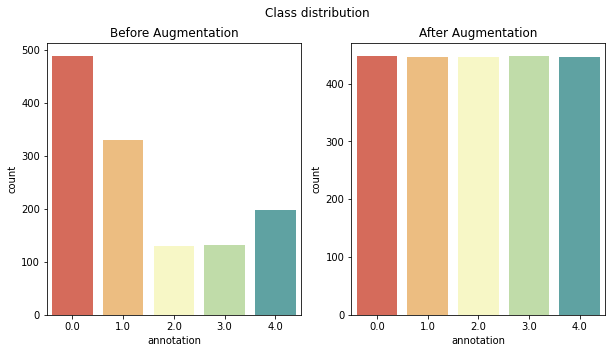

In [ ]:
# Read the Original and augmented train label dataframe
df = pd.read_csv('/content/drive/MyDrive/SoyabeanWilting/data/TrainAnnotations.csv')
train_df = pd.DataFrame(train_label, columns=["annotation"])

fig, axes = plt.subplots(1, 2, sharex=True, figsize=(10,5))
fig.suptitle('Class distribution')

# Plot class distribution before and after augmentation
sns.countplot(x="annotation", data=df, palette="Spectral", ax=axes[0])
axes[0].set_title('Before Augmentation')
sns.countplot(x="annotation", data=train_df, palette="Spectral", ax=axes[1])
axes[1].set_title('After Augmentation')
plt.show()

In [ ]:
#depth = 5
#tf.one_hot(train_label, depth)
#tf.one_hot(val_label, depth)

In [ ]:
# Obtain Train and Validation dataset
train_dataset = tf.data.Dataset.from_tensor_slices((train_data, train_label))
val_dataset = tf.data.Dataset.from_tensor_slices((val_data, val_label))
print(train_dataset)

<TensorSliceDataset shapes: ((224, 224, 3), ()), types: (tf.float64, tf.float64)>


In [ ]:
# All images will be resized to 224 X 224 and cast to 0-1 float format
IMG_SIZE = 224 
def format_example(image, label):
    image = tf.cast(image, tf.float32)
    image = (image/255) 
    image = tf.image.resize(image, (IMG_SIZE, IMG_SIZE))
    return image, label

In [ ]:
train = train_dataset.map(format_example)
validation = val_dataset.map(format_example)
print(type(train))

<class 'tensorflow.python.data.ops.dataset_ops.MapDataset'>


In [ ]:
# Define batch size and input image size
BATCH_SIZE = 64
IMG_SHAPE = (IMG_SIZE,IMG_SIZE,3)

train_batches = train.batch(BATCH_SIZE)
validation_batches = validation.batch(BATCH_SIZE)

In [ ]:
# Check batch shape
for image_batch, label_batch in train_batches.take(1):
    pass
image_batch.shape

TensorShape([64, 224, 224, 3])

In [ ]:
# Define Base model as VGG16 initialized with Imagenet weights
base_model = tf.keras.applications.VGG16(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')

In [ ]:
# Check output feature shape of the base model
feature_batch = base_model(image_batch)
print(feature_batch.shape)

(64, 7, 7, 512)


In [ ]:
# Make the base model trainable
base_model.trainable = True

In [ ]:
# Fine-tune from this layer onwards
fine_tune_at = 15

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
    layer.trainable =  False

In [ ]:
# Add layers after the base model
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)

In [ ]:
prediction_layer = tf.keras.layers.Dense(5,kernel_regularizer=regularizers.l1_l2(l1=0.01,l2=0.01))
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape) 

(64, 5)


In [ ]:
l1 = 0.0013
l2 = 0.0005
mom = 0.9
lr = 0.0001
drop = 0.6

In [ ]:
model = tf.keras.Sequential([    #,kernel_initializer=initializers.LecunNormal()
  base_model,
  tf.keras.layers.Conv2D(512, 5, activation="elu"),
  tf.keras.layers.MaxPool2D(pool_size=(3,3)),
  tf.keras.layers.GlobalAveragePooling2D(),

  tf.keras.layers.Dense(512,
                        activation='elu',
                        kernel_regularizer=regularizers.l1(l1=l1),
                        kernel_initializer=initializers.he_normal()),
  Dropout(drop), 
  tf.keras.layers.Dense(256,
                        activation='elu',
                        kernel_regularizer=regularizers.l1(l1=l1),
                        kernel_initializer=initializers.he_normal()),
  BatchNormalization(momentum=0.9,epsilon=0.01),
  #Dropout(drop), 
  tf.keras.layers.Dense(128,
                        activation='elu',
                        kernel_regularizer=regularizers.l1(l1=l1),
                        kernel_initializer=initializers.he_normal()),
  Dropout(drop), 
  tf.keras.layers.Dense(64,
                        activation='elu',
                        kernel_regularizer=regularizers.l1(l1=l1),
                        kernel_initializer=initializers.he_normal()),
  BatchNormalization(momentum=0.9,epsilon=0.01),
  #Dropout(drop), 
  tf.keras.layers.Dense(32,
                        activation='elu',
                        kernel_regularizer=regularizers.l1(l1=l1),
                        kernel_initializer=initializers.he_normal()),
  Dropout(drop), 
  tf.keras.layers.Dense(16,activation='relu',kernel_regularizer=regularizers.l1(l1=l1)),
  tf.keras.layers.Dense(5, activation="softmax"),
])

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 7, 7, 512)         14714688  
_________________________________________________________________
conv2d (Conv2D)              (None, 3, 3, 512)         6554112   
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 1, 1, 512)         0         
_________________________________________________________________
global_average_pooling2d (Gl (None, 512)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 512)               262656    
_________________________________________________________________
dropout (Dropout)            (None, 512)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 256)               1

In [ ]:
model.compile(optimizer=tf.keras.optimizers.Adam(lr=lr,),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=[tf.keras.metrics.SparseCategoricalAccuracy(name='accuracy')])

In [ ]:
len(model.trainable_variables)

26

In [ ]:
w_arr = compute_class_weight('balanced', np.unique(train_label), train_label)
weights = {i : w_arr[i] for i in range(5)}
weights

{0: 0.9973214285714286,
 1: 1.0017937219730941,
 2: 1.0017937219730941,
 3: 0.9973214285714286,
 4: 1.0017937219730941}

In [ ]:
H = model.fit(train_data, train_label,
	validation_data=(val_data, val_label),
  batch_size= BATCH_SIZE,
  epochs=50, 
  class_weight=weights)

Epoch 1/50
35/35 [==============================] - 7s 206ms/step - loss: 31.8484 - accuracy: 0.2158 - val_loss: 31.0934 - val_accuracy: 0.2736
Epoch 2/50
35/35 [==============================] - 5s 154ms/step - loss: 30.4388 - accuracy: 0.2207 - val_loss: 29.6996 - val_accuracy: 0.2537
Epoch 3/50
35/35 [==============================] - 5s 154ms/step - loss: 29.0501 - accuracy: 0.2225 - val_loss: 28.3344 - val_accuracy: 0.3134
Epoch 4/50
35/35 [==============================] - 5s 154ms/step - loss: 27.7010 - accuracy: 0.2440 - val_loss: 26.9898 - val_accuracy: 0.3284
Epoch 5/50
35/35 [==============================] - 5s 154ms/step - loss: 26.4047 - accuracy: 0.2842 - val_loss: 25.7500 - val_accuracy: 0.3383
Epoch 6/50
35/35 [==============================] - 5s 154ms/step - loss: 25.1756 - accuracy: 0.2865 - val_loss: 24.5151 - val_accuracy: 0.6070
Epoch 7/50
35/35 [==============================] - 5s 154ms/step - loss: 23.9733 - accuracy: 0.3438 - val_loss: 23.3142 - val_accuracy:

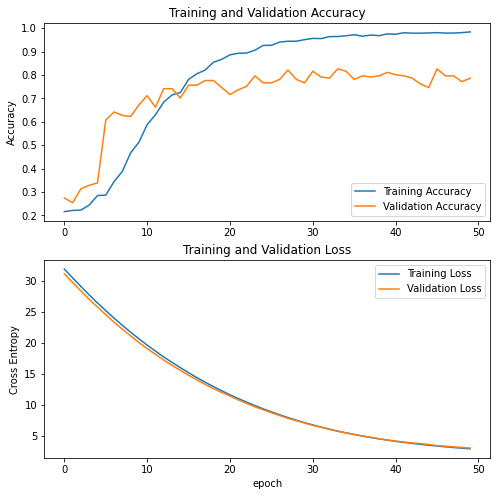

In [ ]:
acc = H.history['accuracy']
val_acc = H.history['val_accuracy']

loss = H.history['loss']
val_loss = H.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
#plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
#plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [ ]:
import datetime

now = datetime.datetime.now()
date_time = now.strftime("%d.%m.%H:%M:%S")
print("date and time:",date_time)
acc = val_acc[-1]
acc = round(acc, 4)
print(acc)

date and time: 14.12.05:00:57
0.7861


In [ ]:
model.save('/content/drive/MyDrive/SoyabeanWilting/'+str(acc)+"."+date_time+'.h5')

In [ ]:
test_data = x_test

In [ ]:
probability_model = tf.keras.Sequential([model, tf.keras.layers.Softmax()])
predictions_test = probability_model.predict(test_data)

In [ ]:
predictions_test[:10]

array([[0.18175967, 0.3520079 , 0.15618159, 0.15479492, 0.15525587],
       [0.14890437, 0.14906505, 0.14891683, 0.14891598, 0.40419772],
       [0.14887321, 0.14895354, 0.14887774, 0.14887567, 0.40441984],
       [0.1513091 , 0.39976218, 0.1497607 , 0.14947951, 0.14968857],
       [0.14931516, 0.4028039 , 0.14920704, 0.14909413, 0.14957967],
       [0.1489687 , 0.4040463 , 0.1489698 , 0.14892426, 0.14909099],
       [0.21856792, 0.3053417 , 0.15943274, 0.15814829, 0.15850934],
       [0.14891887, 0.14911085, 0.14893596, 0.14893392, 0.40410042],
       [0.1488627 , 0.14891388, 0.14886463, 0.14886321, 0.40449563],
       [0.14940624, 0.40188533, 0.14943866, 0.14923811, 0.1500316 ]],
      dtype=float32)

In [ ]:
import csv
pred = []
p0 = 0
p1 = 0
p2 = 0
p3 = 0
p4 = 0
for i in range(len(test_data)):
    if np.argmax(predictions_test[i]) == 0: 
        p0 += 1
        pred.append([1,0,0,0,0])
    elif np.argmax(predictions_test[i]) == 1: 
        p1 += 1
        pred.append([0,1,0,0,0])
    elif np.argmax(predictions_test[i]) == 2: 
        p2 += 1
        pred.append([0,0,1,0,0])
    elif np.argmax(predictions_test[i]) == 3: 
        p3 += 1
        pred.append([0,0,0,1,0])
    elif np.argmax(predictions_test[i]) == 4: 
        p4 += 1
        pred.append([0,0,0,0,1])
print(p0,p1,p2,p3,p4)

13 131 1 0 55
